# Imports

In [42]:
import sys
import time
import cProfile, pstats
import pathlib
import joblib
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import itertools

from sklearn.model_selection import KFold, GridSearchCV

if pathlib.Path().parent.resolve().absolute().as_posix() not in sys.path:
    sys.path.append(pathlib.Path().parent.resolve().absolute().as_posix())

from pilot import Pilot, ensemble, Tree

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

OUTPUTPATH = pathlib.Path().absolute() / 'Output'

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [2]:
def highlight(data, kind='max', color='black', background_color='lightgreen'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'color: {}; background-color: {}'.format(color, background_color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        if kind == 'max':
            highlight = data == data.max()
        elif kind == 'min':
            highlight = data == data.min()
        return [attr if v else '' for v in highlight]
    else:  # from .apply(axis=None)
        if kind == 'max':
            highlight = data == data.max().max()
        elif kind == 'min':
            highlight = data == data.min().min()
        return pd.DataFrame(np.where(highlight, attr, ''),
                            index=data.index, columns=data.columns)

# Load data

In [4]:
DATAPATH = pathlib.Path().absolute() / 'Data'
datasets = {
    'abalone': {'categorical': [0]}, # sex
    'airfoil': {'categorical': [-1]},
    'Bias_correction_ucl': {'categorical': [0]}, # station 
    'bodyfat_preprocessed': {'categorical': [-1]},
    'boston': {'categorical': [3]}, # Charles river dummy
    'communities': {'categorical': [-1]}, # 119 = LemasGangUnitDeploy
    'concrete': {'categorical': [-1]},
    'diabetes': {'categorical': [-1]},
    'electricity': {'categorical': [-1]},
    'energy': {'categorical': [5]}, # Orientation (X6)
    'ga_preprocessed': {'categorical': [6]}, # Research
    'housing': {'categorical': [-1]},
    'ozone_preprocessed': {'categorical': [10, 11]},
    'residential': {'categorical': [-1]},
    'ribo_preprocessed': {'categorical': [-1]},
    'SeoulBikeData': {'categorical': [-1]}, # 10 = seasons
    'skills': {'categorical': [-1]},
    'superconductor': {'categorical': [-1]},
    'Walmart_preprocessed': {'categorical': [0]},
    'wine': {'categorical': [-1]}
}

In [5]:
for d in datasets:
    df = pd.read_csv(DATAPATH / f'{d}.csv')
    X = df.drop(columns='target').values
    y = df['target'].values
    datasets[d]['data'] = X, y


# Slow datasets

In [62]:
slow_datasets = ['superconductor', 'Bias_correction_ucl', 'communities', 'housing', 'ribo_preprocessed']

## communities

In [8]:
data = datasets['communities']

In [9]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

pilot = GridSearchCV(
    estimator=ensemble.RandomForestPilot(),
    param_grid={
        'n_estimators': [100],
        'max_depth': [10],
        'truncation_factor': [1],
        'min_sample_split': [2],
        'min_sample_leaf':  [1],
        'n_features': [0.7],
        'rel_tolerance': [0.01],
        'df_settings': [{'con': 1, 'lin': 2}, {'con': 5, 'lin': 2}],
        'min_unique_values_regression': [2, 5]
        
    }, 
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=10
)


X, y = data['data']

pilot.fit(X, y, categorical_idx=np.array(data['categorical']))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 4/5; 1/4] START df_settings={'con': 1, 'lin': 2}, max_depth=10, min_sample_leaf=1, min_sample_split=2, min_unique_values_regression=2, n_estimators=100, n_features=0.7, rel_tolerance=0.01, truncation_factor=1
[CV 2/5; 1/4] START df_settings={'con': 1, 'lin': 2}, max_depth=10, min_sample_leaf=1, min_sample_split=2, min_unique_values_regression=2, n_estimators=100, n_features=0.7, rel_tolerance=0.01, truncation_factor=1
[CV 2/5; 3/4] START df_settings={'con': 5, 'lin': 2}, max_depth=10, min_sample_leaf=1, min_sample_split=2, min_unique_values_regression=2, n_estimators=100, n_features=0.7, rel_tolerance=0.01, truncation_factor=1
[CV 4/5; 2/4] START df_settings={'con': 1, 'lin': 2}, max_depth=10, min_sample_leaf=1, min_sample_split=2, min_unique_values_regression=5, n_estimators=100, n_features=0.7, rel_tolerance=0.01, truncation_factor=1
[CV 5/5; 2/4] START df_settings={'con': 1, 'lin': 2}, max_depth=10, min_sample_leaf=1, m

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestPilot(), n_jobs=-1,
             param_grid={'df_settings': [{'con': 1, 'lin': 2},
                                         {'con': 5, 'lin': 2}],
                         'max_depth': [10], 'min_sample_leaf': [1],
                         'min_sample_split': [2],
                         'min_unique_values_regression': [2, 5],
                         'n_estimators': [100], 'n_features': [0.7],
                         'rel_tolerance': [0.01], 'truncation_factor': [1]},
             scoring='neg_mean_squared_error', verbose=10)

In [11]:
pd.DataFrame(pilot.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_df_settings,param_max_depth,param_min_sample_leaf,param_min_sample_split,param_min_unique_values_regression,param_n_estimators,...,param_truncation_factor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,802.126932,25.468470,17.263800,2.492712,"{'con': 1, 'lin': 2}",10,1,2,2,100,...,1,"{'df_settings': {'con': 1, 'lin': 2}, 'max_dep...",-0.017437,-0.015085,-0.024264,-0.015214,-0.019035,-0.018207,0.003367,4
1,714.450477,25.750714,16.746816,4.116439,"{'con': 1, 'lin': 2}",10,1,2,5,100,...,1,"{'df_settings': {'con': 1, 'lin': 2}, 'max_dep...",-0.017402,-0.014625,-0.023212,-0.015706,-0.018528,-0.017895,0.002980,1
2,955.775095,81.816420,13.893825,4.683008,"{'con': 5, 'lin': 2}",10,1,2,2,100,...,1,"{'df_settings': {'con': 5, 'lin': 2}, 'max_dep...",-0.017182,-0.015102,-0.023661,-0.015325,-0.018637,-0.017982,0.003120,2
3,817.215779,20.540776,12.976625,3.780379,"{'con': 5, 'lin': 2}",10,1,2,5,100,...,1,"{'df_settings': {'con': 5, 'lin': 2}, 'max_dep...",-0.017294,-0.014635,-0.023626,-0.015790,-0.018618,-0.017992,0.003122,3


## Housing

In [5]:
data = datasets['housing']
cv = KFold(n_splits=3, shuffle=True, random_state=42)

pilot = GridSearchCV(
    estimator=ensemble.RandomForestPilot(),
    param_grid={
        'n_estimators': [100],
        'max_depth': [10],
        'truncation_factor': [1],
        'min_sample_split': [2],
        'min_sample_leaf':  [1],
        'n_features': [0.7],
        'rel_tolerance': [0.01],
        'df_settings': [{'con': 1, 'lin': 2}, {'con': 5, 'lin': 2}],
        'min_unique_values_regression': [2, 5]
        
    }, 
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=10
)


X, y = data['data']

pilot.fit(X, y, categorical_idx=np.array(data['categorical']))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START df_settings={'con': 1, 'lin': 2}, max_depth=10, min_sample_leaf=1, min_sample_split=2, min_unique_values_regression=2, n_estimators=100, n_features=0.7, rel_tolerance=0.01, truncation_factor=1
[CV 1/3; 3/4] START df_settings={'con': 5, 'lin': 2}, max_depth=10, min_sample_leaf=1, min_sample_split=2, min_unique_values_regression=2, n_estimators=100, n_features=0.7, rel_tolerance=0.01, truncation_factor=1
[CV 3/3; 1/4] START df_settings={'con': 1, 'lin': 2}, max_depth=10, min_sample_leaf=1, min_sample_split=2, min_unique_values_regression=2, n_estimators=100, n_features=0.7, rel_tolerance=0.01, truncation_factor=1
[CV 2/3; 2/4] START df_settings={'con': 1, 'lin': 2}, max_depth=10, min_sample_leaf=1, min_sample_split=2, min_unique_values_regression=5, n_estimators=100, n_features=0.7, rel_tolerance=0.01, truncation_factor=1
[CV 2/3; 1/4] START df_settings={'con': 1, 'lin': 2}, max_depth=10, min_sample_leaf=1, m

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestPilot(), n_jobs=-1,
             param_grid={'df_settings': [{'con': 1, 'lin': 2},
                                         {'con': 5, 'lin': 2}],
                         'max_depth': [10], 'min_sample_leaf': [1],
                         'min_sample_split': [2],
                         'min_unique_values_regression': [2, 5],
                         'n_estimators': [100], 'n_features': [0.7],
                         'rel_tolerance': [0.01], 'truncation_factor': [1]},
             scoring='neg_mean_squared_error', verbose=10)

In [6]:
pd.DataFrame(pilot.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_df_settings,param_max_depth,param_min_sample_leaf,param_min_sample_split,param_min_unique_values_regression,param_n_estimators,param_n_features,param_rel_tolerance,param_truncation_factor,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1587.498380,82.235764,93.708236,14.771144,"{'con': 1, 'lin': 2}",10,1,2,2,100,0.7,0.01,1,"{'df_settings': {'con': 1, 'lin': 2}, 'max_dep...",-0.224506,-0.218425,-0.223815,-0.222249,0.002718,4
1,1492.228304,12.391666,117.706067,4.735896,"{'con': 1, 'lin': 2}",10,1,2,5,100,0.7,0.01,1,"{'df_settings': {'con': 1, 'lin': 2}, 'max_dep...",-0.222503,-0.218014,-0.223980,-0.221499,0.002537,3
2,1601.638801,2.474606,113.205394,1.514599,"{'con': 5, 'lin': 2}",10,1,2,2,100,0.7,0.01,1,"{'df_settings': {'con': 5, 'lin': 2}, 'max_dep...",-0.218114,-0.213255,-0.218575,-0.216648,0.002407,2
3,1715.446608,56.496356,60.821141,27.828951,"{'con': 5, 'lin': 2}",10,1,2,5,100,0.7,0.01,1,"{'df_settings': {'con': 5, 'lin': 2}, 'max_dep...",-0.216784,-0.212508,-0.218533,-0.215942,0.002531,1


# cProfile

In [16]:
data = datasets['housing']
X, y = data['data']
categorical = data['categorical']

pilot = Pilot.PILOT(max_depth=10, min_sample_split=2, min_sample_leaf=1, truncation_factor=1, rel_tolerance=0.01, min_unique_values_regression=2)

cProfile.run('pilot.fit(X, y, categorical_idx=np.array(categorical))', sort='cumtime', filename='/home/servot82/PILOT/Output/pilot.prof')

In [17]:
p = pstats.Stats('/home/servot82/PILOT/Output/pilot.prof')
p.sort_stats("cumulative").print_stats()

Thu Jul 13 11:06:54 2023    /home/servot82/PILOT/Output/pilot.prof

         99680 function calls (96993 primitive calls) in 17.878 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   17.878   17.878 {built-in method builtins.exec}
        1    0.000    0.000   17.878   17.878 <string>:1(<module>)
        1    0.000    0.000   17.878   17.878 /home/servot82/PILOT/pilot/Pilot.py:803(fit)
    672/1    0.059    0.000   17.869   17.869 /home/servot82/PILOT/pilot/Pilot.py:646(build_tree)
      672   17.695    0.026   17.728    0.026 /home/servot82/PILOT/pilot/Pilot.py:85(best_split)
     5376    0.007    0.000    0.057    0.000 /home/servot82/miniconda3/envs/pilot/lib/python3.10/site-packages/numba/core/typing/typeof.py:32(typeof)
     2520    0.004    0.000    0.047    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
6048/5376    0.007    0.000    0.044    0.000 /home/ser

In [20]:
p.sort_stats(pstats.SortKey.TIME).print_stats()

Thu Jul 13 11:06:54 2023    /home/servot82/PILOT/Output/pilot.prof

         99680 function calls (96993 primitive calls) in 17.878 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      672   17.695    0.026   17.728    0.026 /home/servot82/PILOT/pilot/Pilot.py:85(best_split)
    672/1    0.059    0.000   17.869   17.869 /home/servot82/PILOT/pilot/Pilot.py:646(build_tree)
     2513    0.010    0.000    0.010    0.000 {method 'reduce' of 'numpy.ufunc' objects}
6048/5376    0.007    0.000    0.044    0.000 /home/servot82/miniconda3/envs/pilot/lib/python3.10/functools.py:884(wrapper)
        9    0.007    0.001    0.007    0.001 {method 'argsort' of 'numpy.ndarray' objects}
     5376    0.007    0.000    0.057    0.000 /home/servot82/miniconda3/envs/pilot/lib/python3.10/site-packages/numba/core/typing/typeof.py:32(typeof)
     6048    0.007    0.000    0.012    0.000 /home/servot82/miniconda3/envs/pilot/lib/python3.10/functool

In [21]:
pilot.model_tree.nodes_selected()

{'con': 17, 'lin': 37, 'blin': 27, 'pcon': 3, 'plin': 44, 'pconc': 0}

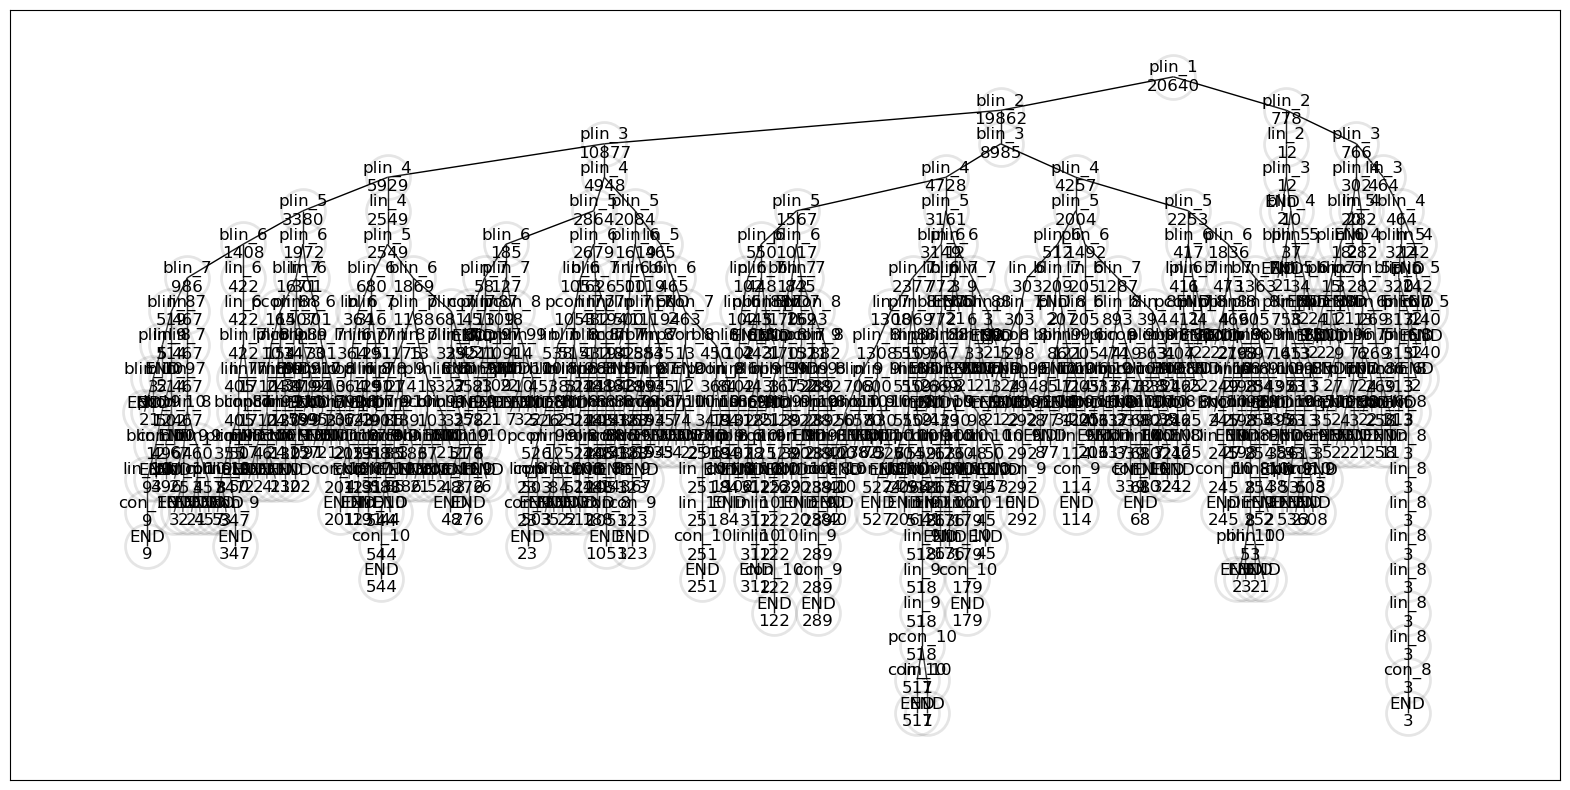

In [23]:
Tree.visualize_tree(pilot.model_tree, training_data=X)

# Lineprofiler

In [33]:
from pilot.Pilot import best_split

In [24]:
%load_ext line_profiler

In [ ]:
%lprun -T /home/servot82/PILOT/Output/bestsplit.prof -f pilot.build_tree  pilot.fit(X, y, categorical_idx=np.array(categorical))

In [36]:
np.array([17276818400.0, 25709551.2]) / 1e9

array([17.2768184 ,  0.02570955])

In [38]:
data = datasets['airfoil']
X, y = data['data']
categorical = data['categorical']

pilot = Pilot.PILOT(max_depth=10, min_sample_split=2, min_sample_leaf=1, truncation_factor=1, rel_tolerance=0.01, min_unique_values_regression=2)

In [ ]:
%lprun -T /home/servot82/PILOT/Output/bestsplit.prof -f pilot.build_tree  pilot.fit(X, y, categorical_idx=np.array(categorical))

In [40]:
np.array([68280000.0, 311780.8]) / 1e9

array([0.06828   , 0.00031178])

# Grid

In [45]:
results = []
for d, data in datasets.items():
    print(d)
    X, y = data['data']	
    categorical = np.array(data['categorical'])
    for min_unique_values_regression in [2, 3, 4, 5]:
        pilot = Pilot.PILOT(max_depth=10, min_sample_split=2, min_sample_leaf=1, truncation_factor=1, rel_tolerance=0.01, min_unique_values_regression=min_unique_values_regression)
        start = time.time()
        pilot.fit(X, y, categorical_idx=categorical)
        end = time.time()
        results.append(dict(dataset=d, time_elapsed=end - start, min_unique_values_regression=min_unique_values_regression, n_samples=X.shape[0], n_feat=X.shape[1], **pilot.model_tree.nodes_selected()))
pd.DataFrame(results).to_csv('/home/servot82/PILOT/Output/pilot_profiling.csv', index=False)
        

abalone
airfoil
Bias_correction_ucl
bodyfat_preprocessed
boston
communities
concrete
diabetes
electricity
energy
ga_preprocessed
housing
ozone_preprocessed
residential
ribo_preprocessed
SeoulBikeData
skills
superconductor
Walmart_preprocessed
wine


In [47]:
results = pd.read_csv('/home/servot82/PILOT/Output/pilot_profiling.csv')

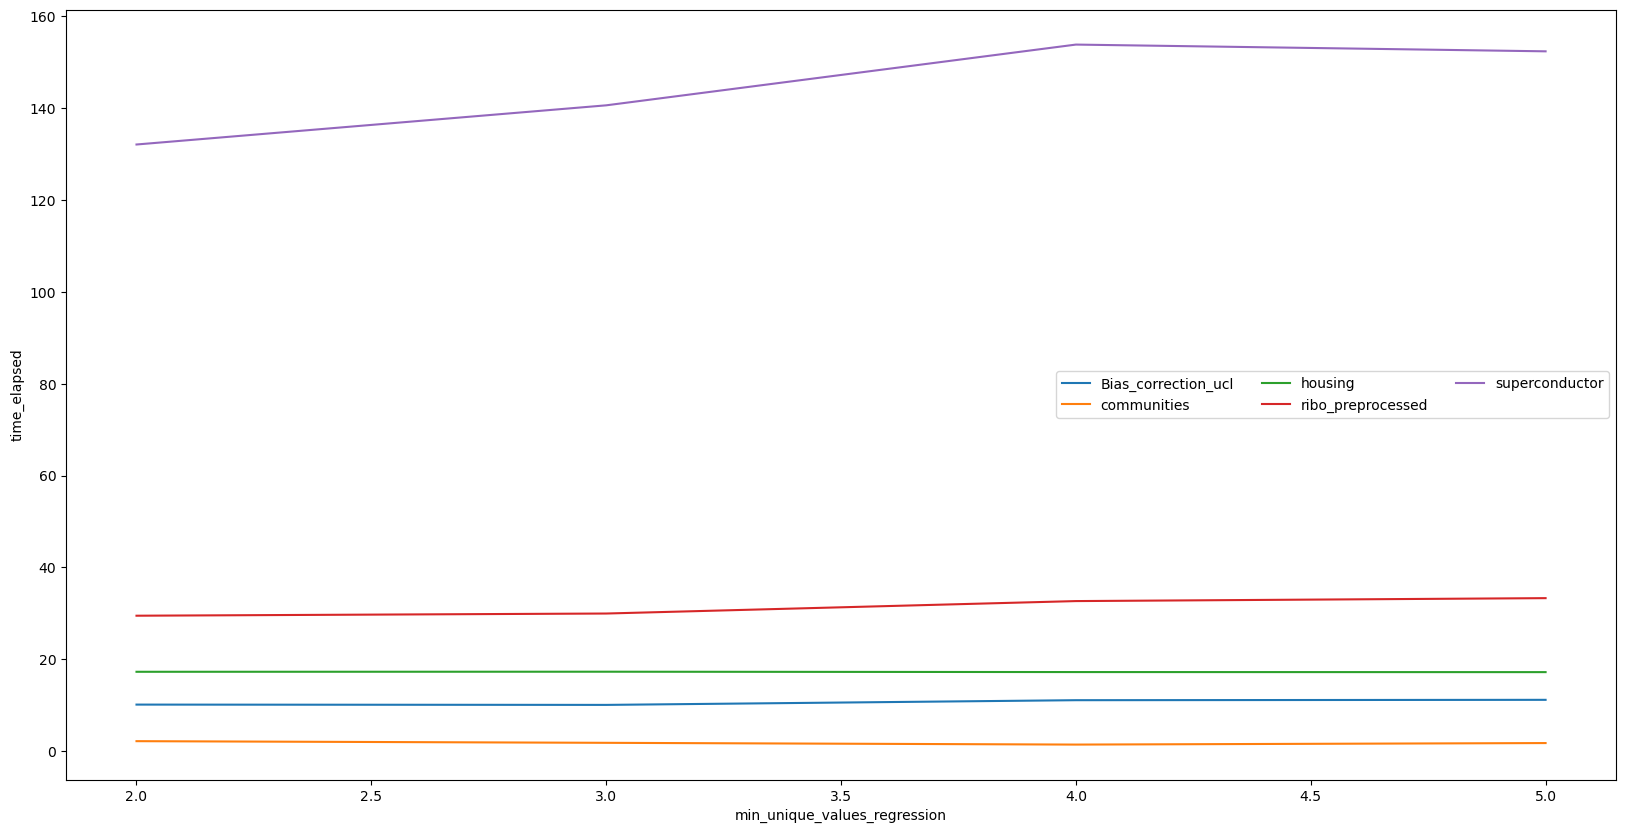

In [64]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=results.loc[results['dataset'].isin(slow_datasets)], x='min_unique_values_regression', y='time_elapsed', hue='dataset')
ax.legend(loc='center right', ncol=3)

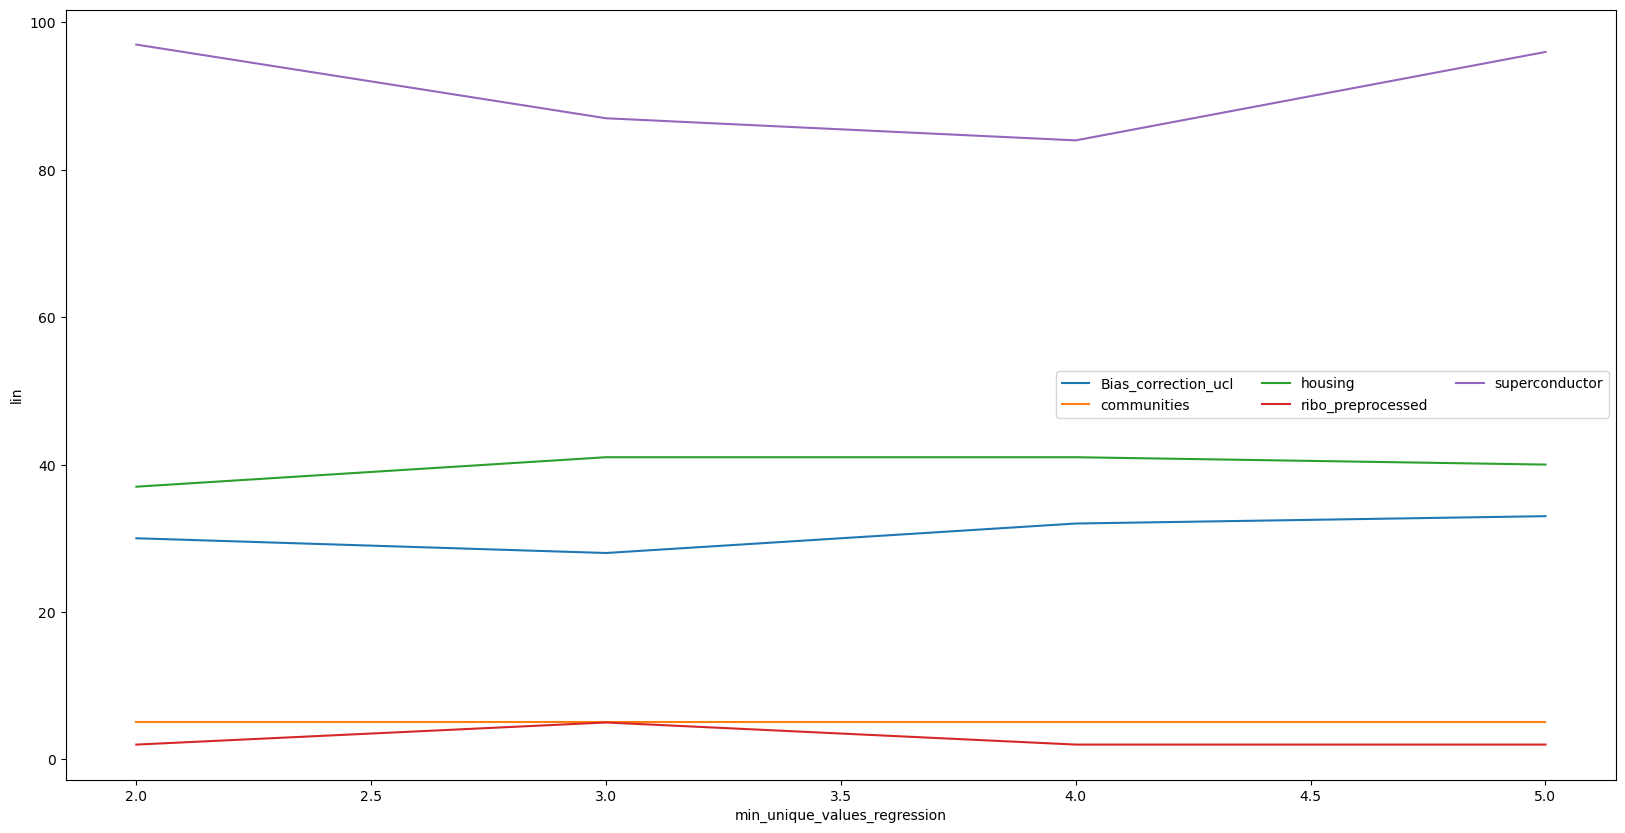

In [63]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=results.loc[results['dataset'].isin(slow_datasets)], x='min_unique_values_regression', y='lin', hue='dataset')
ax.legend(loc='center right', ncol=3)

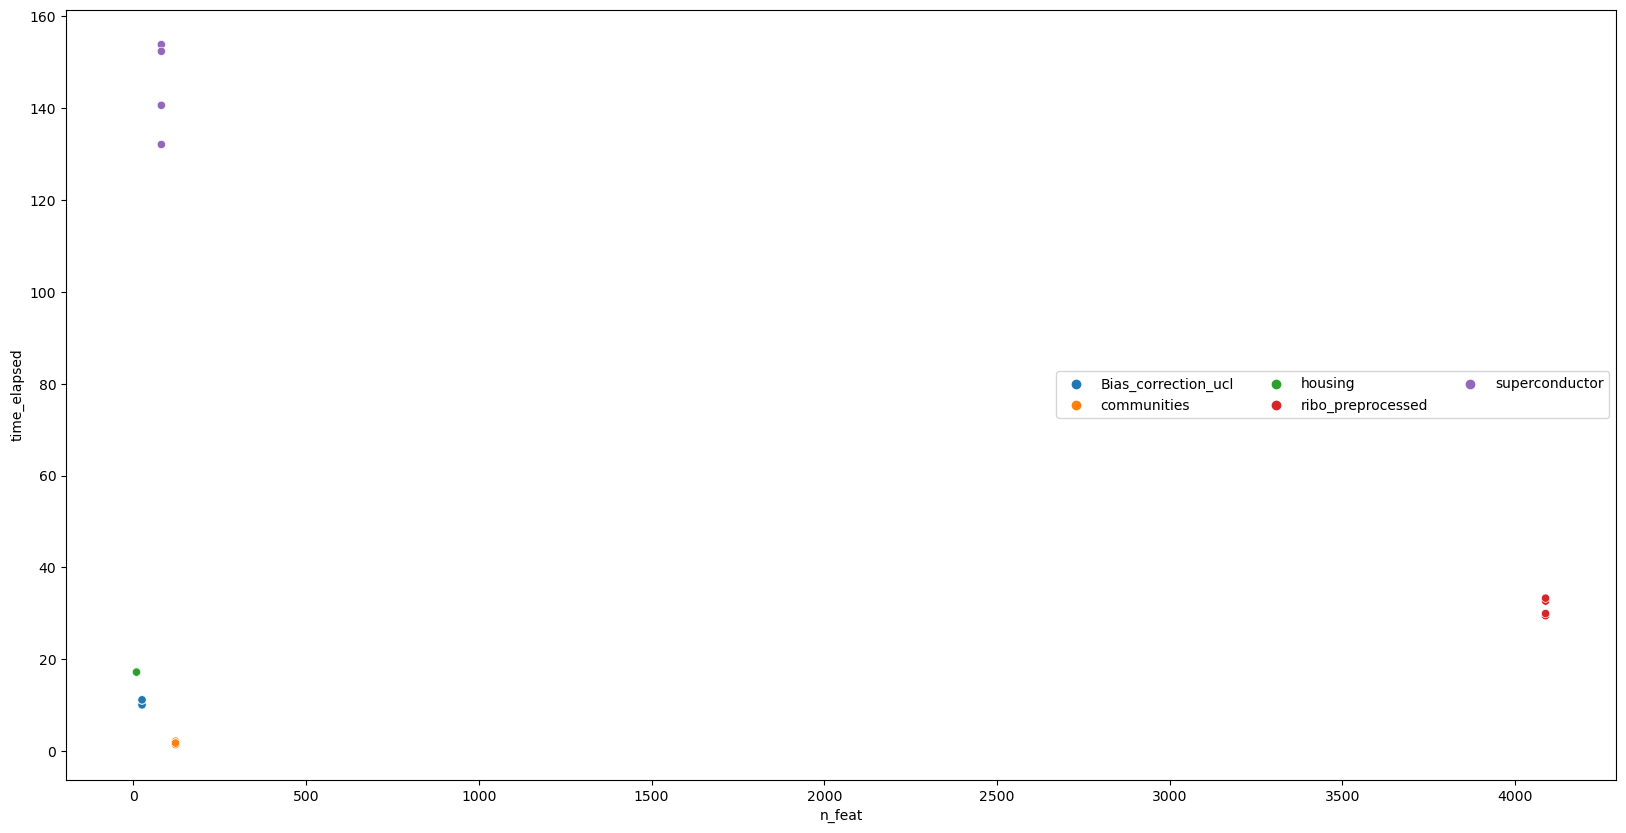

In [65]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(data=results.loc[results['dataset'].isin(slow_datasets)], x='n_feat', y='time_elapsed', hue='dataset')
ax.legend(loc='center right', ncol=3)

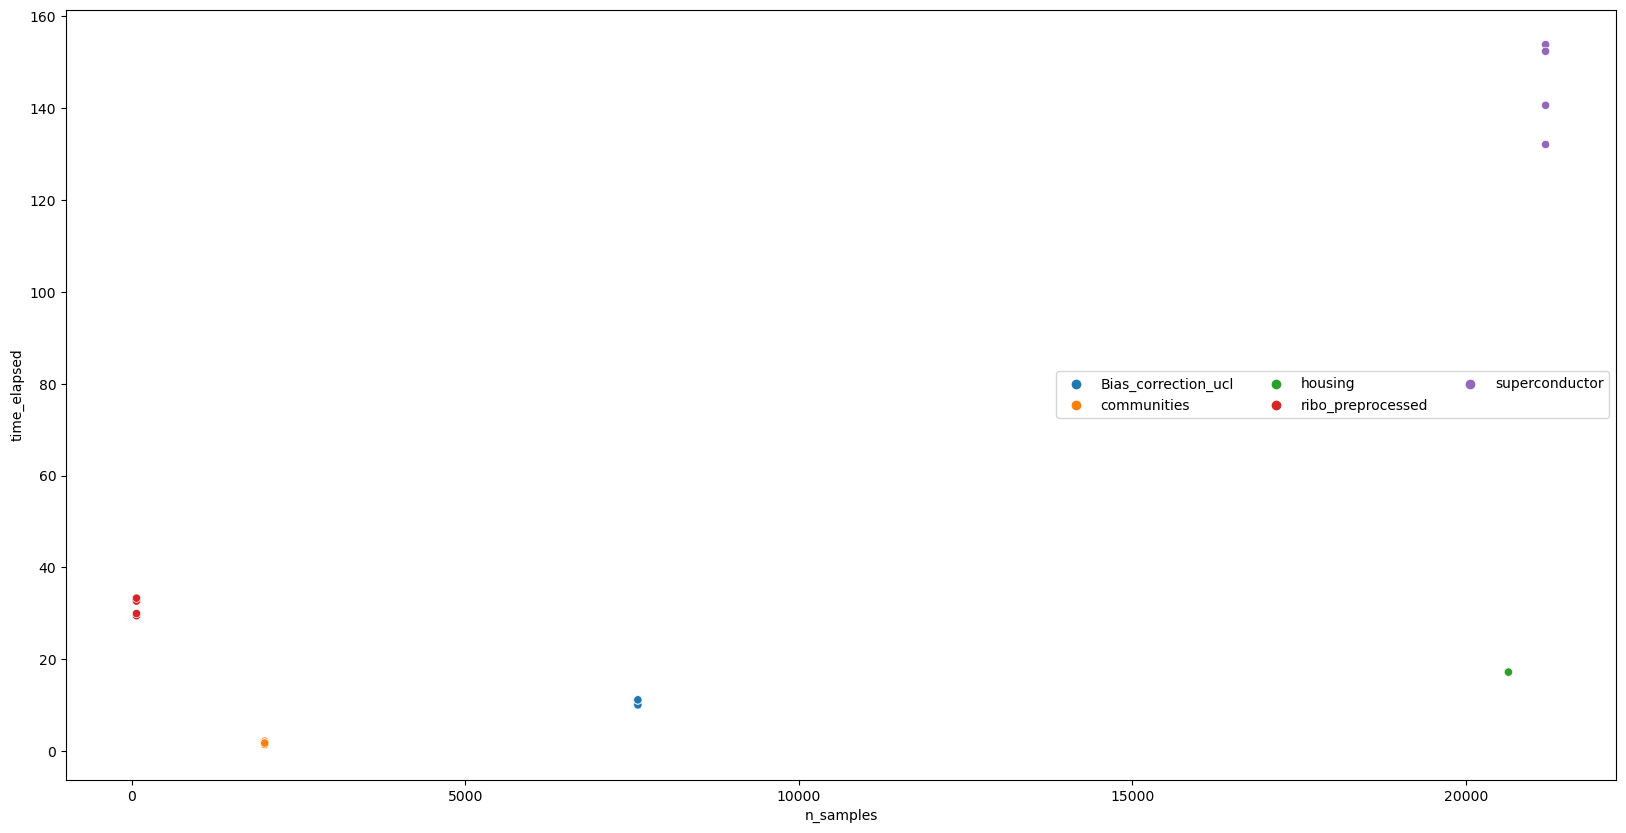

In [68]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(data=results.loc[results['dataset'].isin(slow_datasets)], x='n_samples', y='time_elapsed', hue='dataset')
ax.legend(loc='center right', ncol=3)

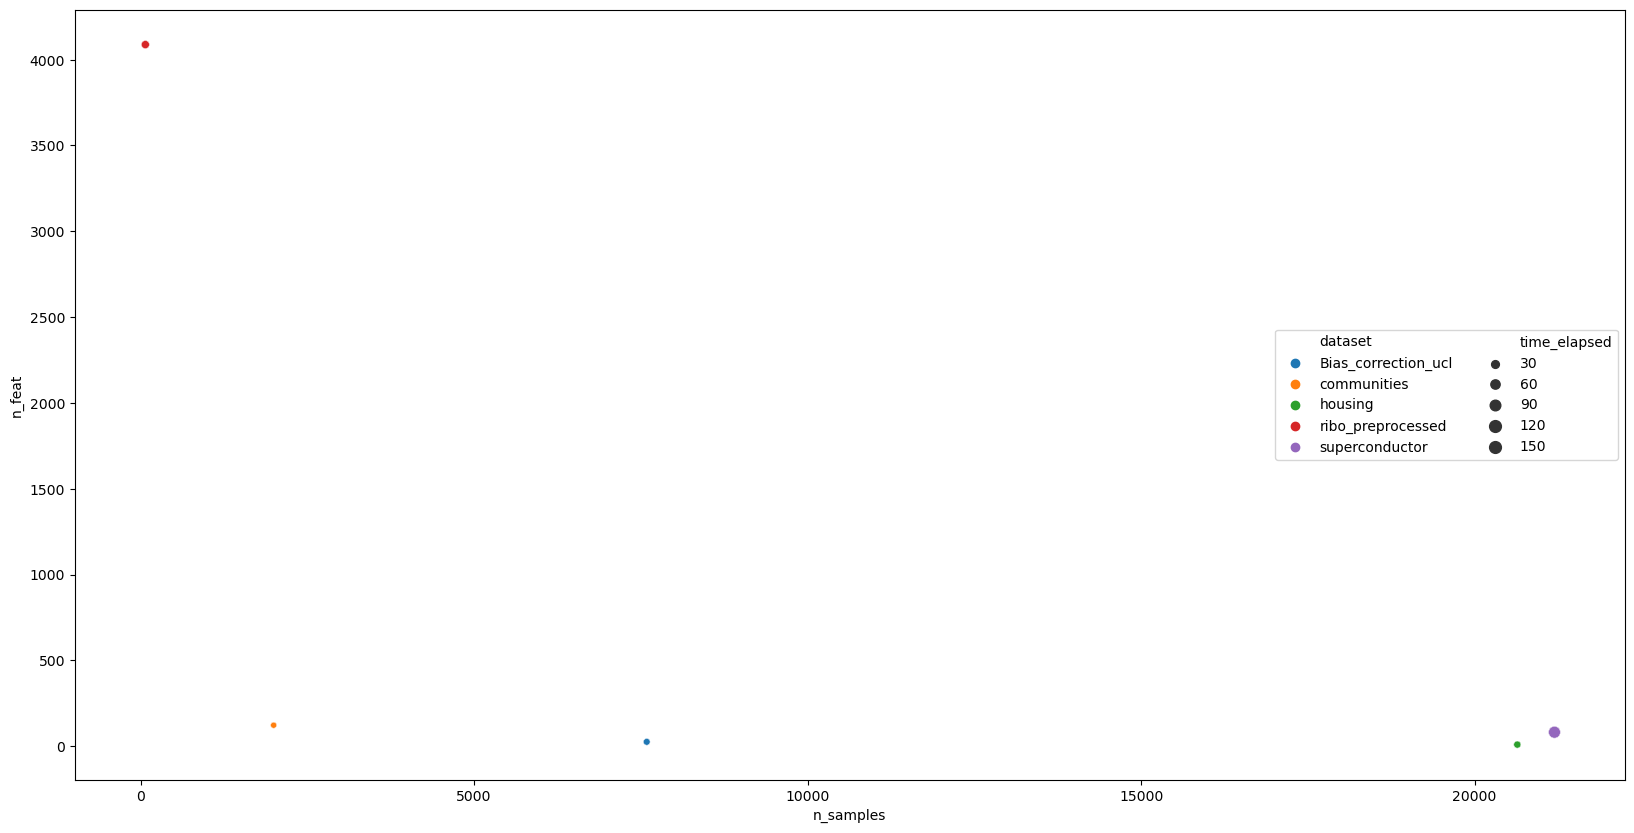

In [75]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(data=results.loc[results['dataset'].isin(slow_datasets)], x='n_samples', y='n_feat', size='time_elapsed', hue='dataset', size_norm=(0, 120))
ax.legend(loc='center right', ncol=2)

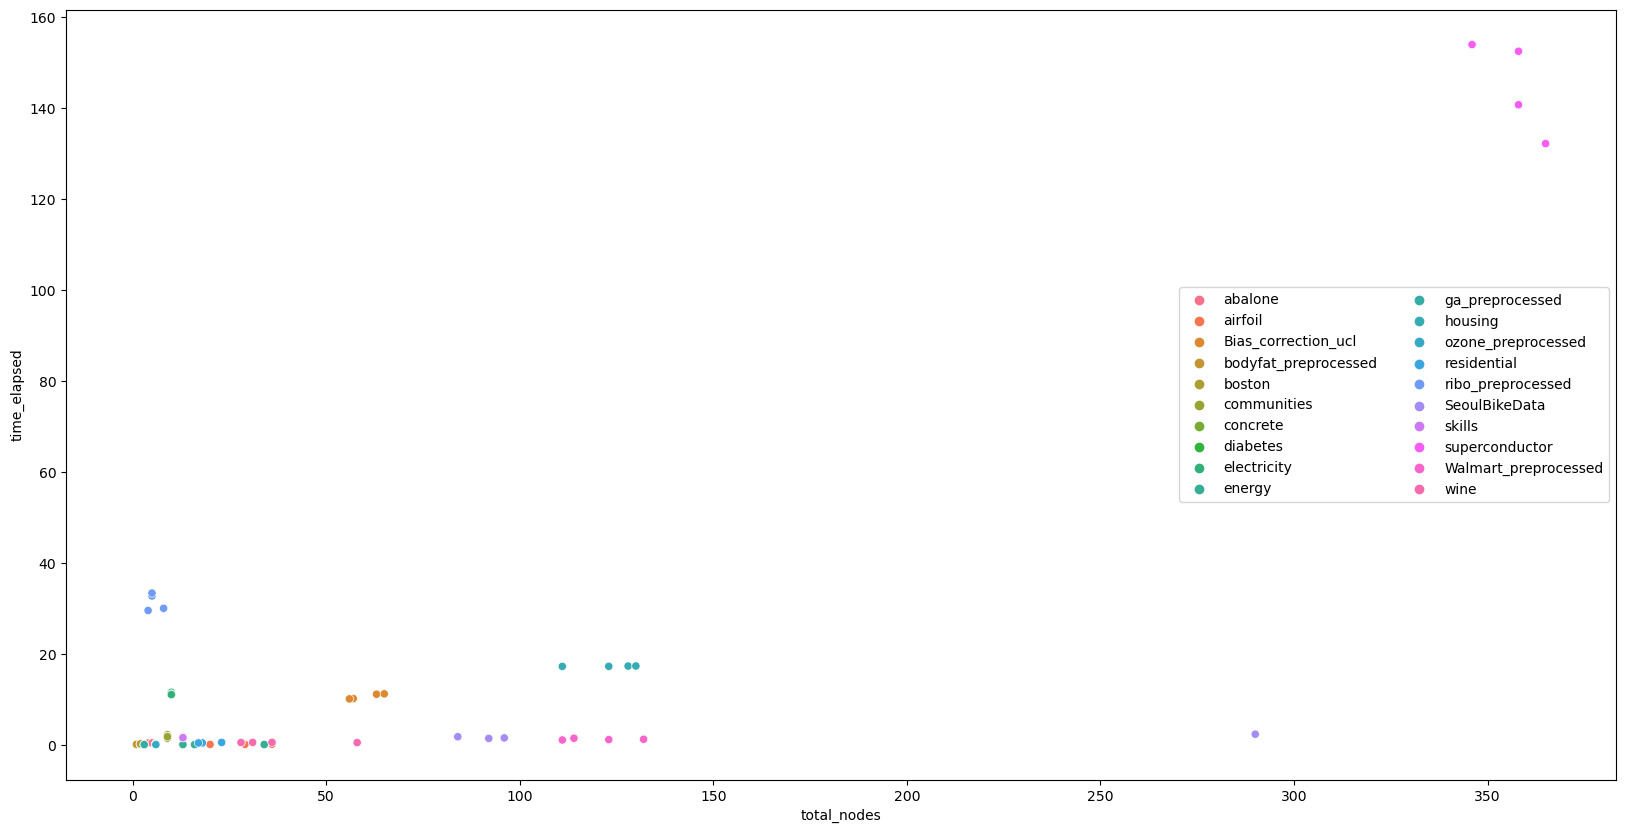

In [78]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(
    data=results.assign(total_nodes=results[['con', 'lin', 'blin', 'pcon', 'plin', 'pconc']].sum(axis=1)),
    x='total_nodes',
    y='time_elapsed',
    hue='dataset'
)
ax.legend(loc='center right', ncol=2)


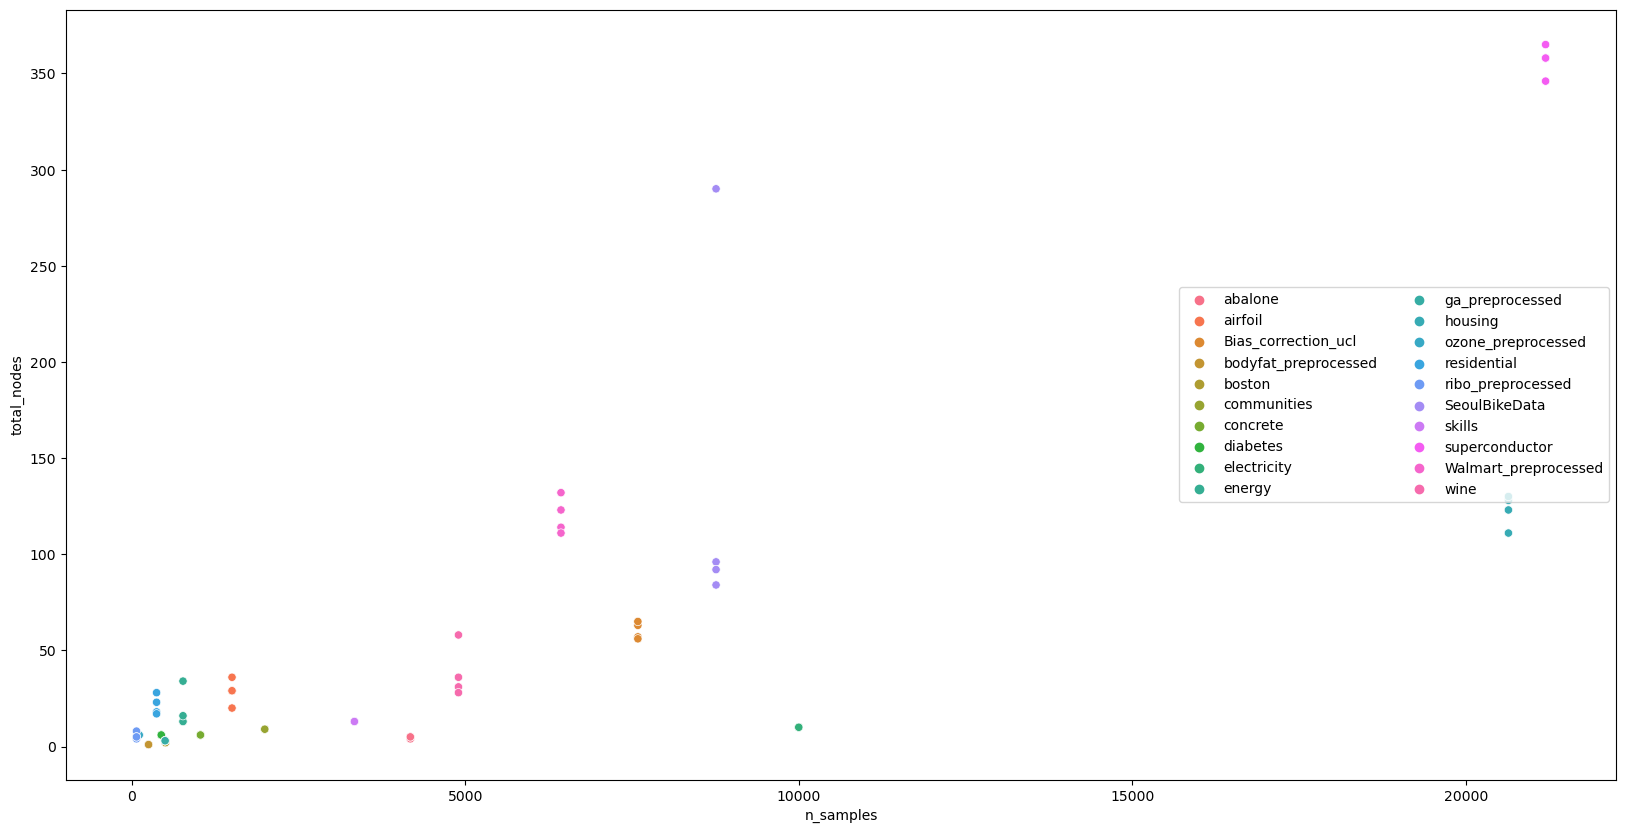

In [80]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(
    data=results.assign(total_nodes=results[['con', 'lin', 'blin', 'pcon', 'plin', 'pconc']].sum(axis=1)),
    x='n_samples',
    y='total_nodes',
    hue='dataset'
)
ax.legend(loc='center right', ncol=2)

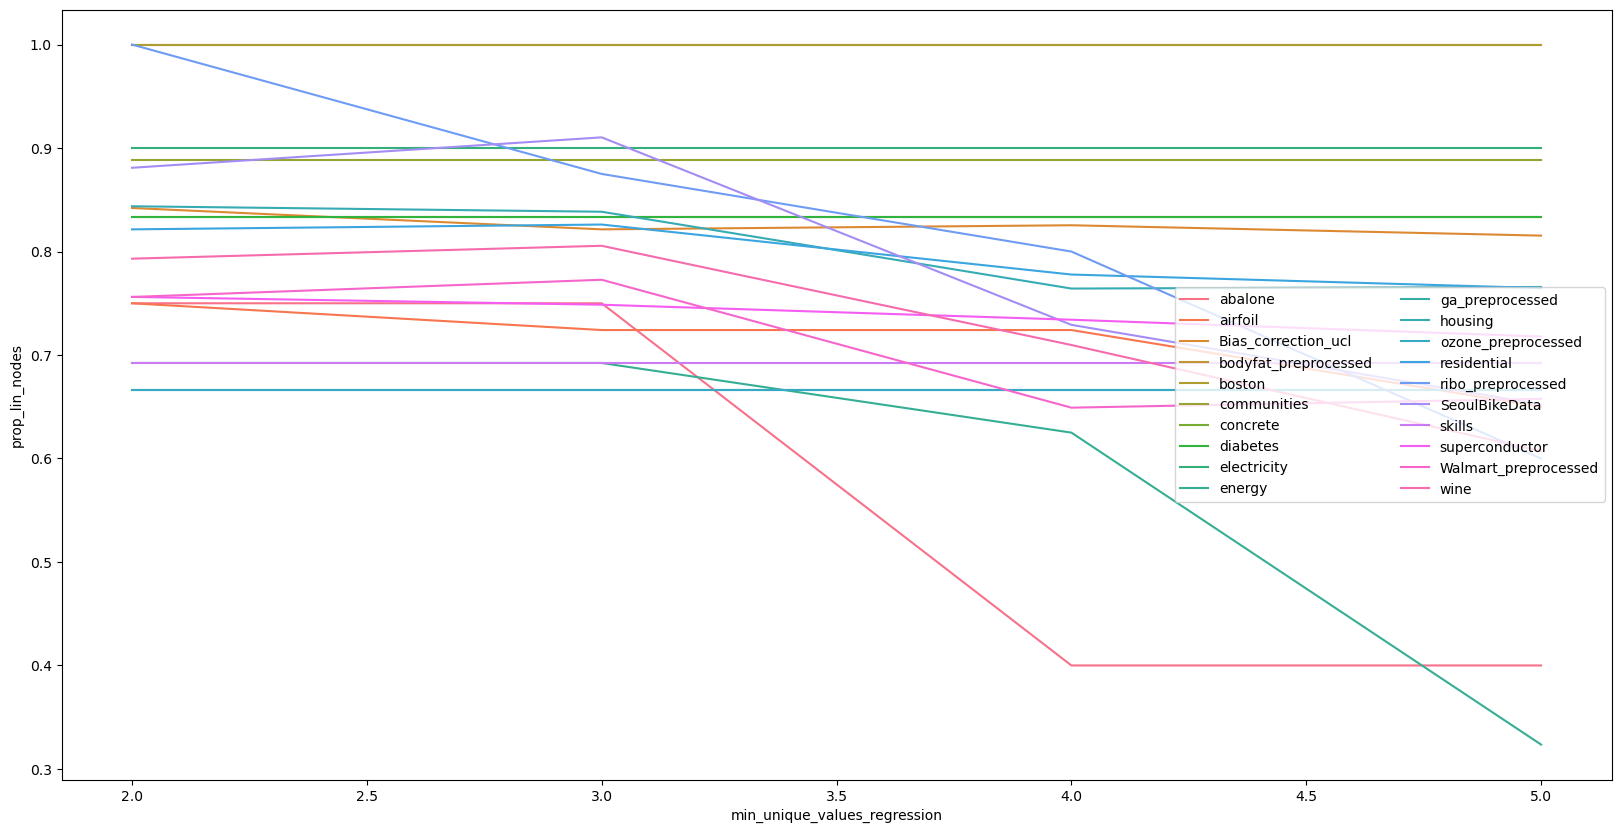

In [84]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(
    data=results.assign(prop_lin_nodes=results[['lin', 'blin', 'plin']].sum(axis=1) / results[['con', 'lin', 'blin', 'pcon', 'plin', 'pconc']].sum(axis=1)),
    x='min_unique_values_regression',
    y='prop_lin_nodes',
    hue='dataset'
)
ax.legend(loc='center right', ncol=2)

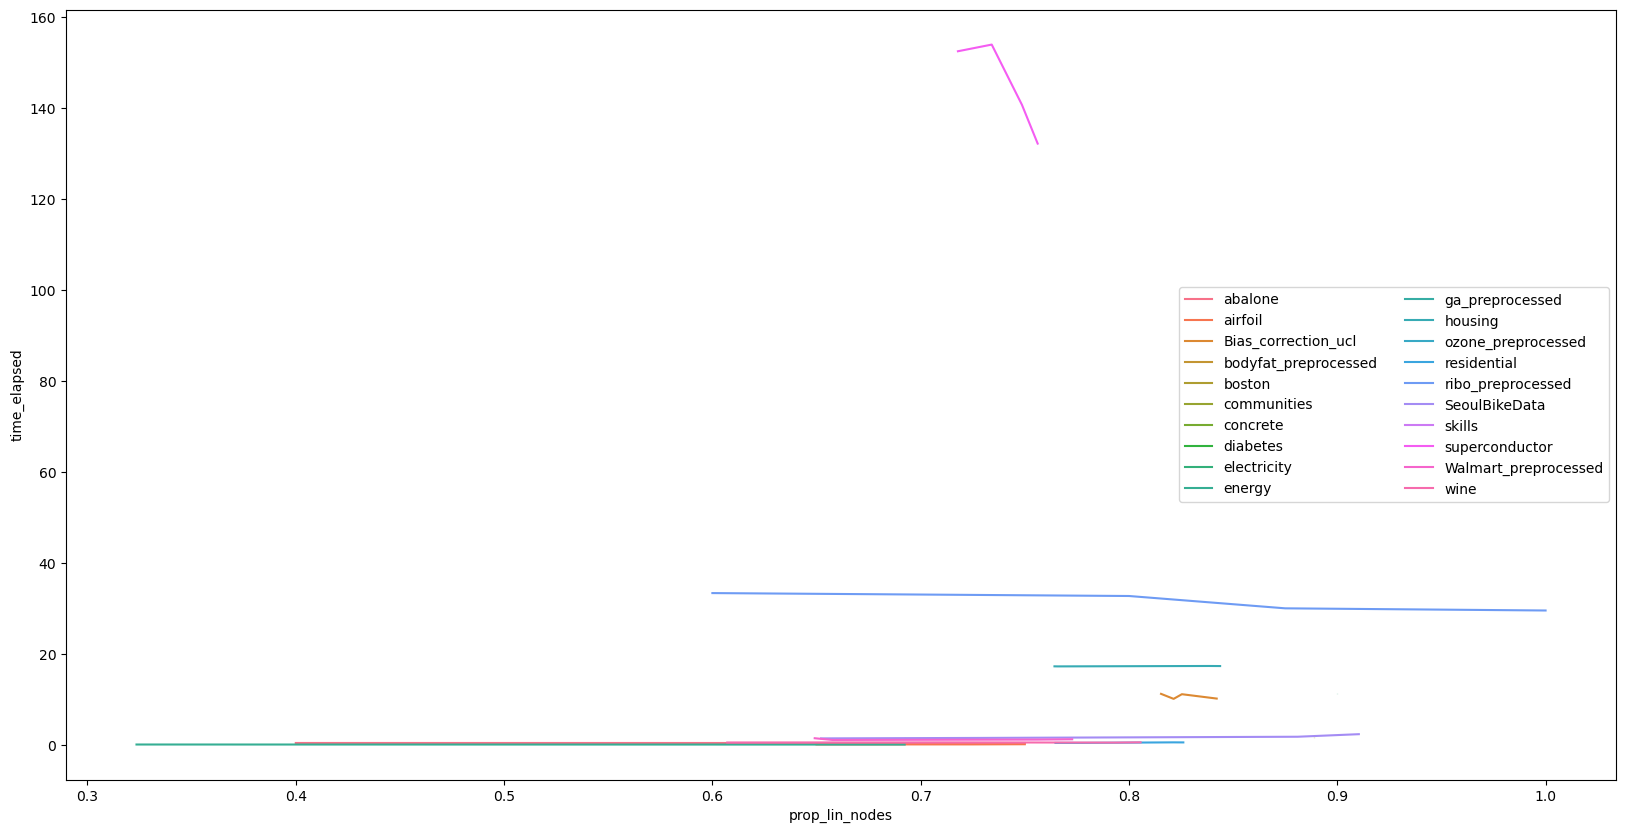

In [85]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(
    data=results.assign(prop_lin_nodes=results[['lin', 'blin', 'plin']].sum(axis=1) / results[['con', 'lin', 'blin', 'pcon', 'plin', 'pconc']].sum(axis=1)),
    x='prop_lin_nodes',
    y='time_elapsed',
    hue='dataset'
)
ax.legend(loc='center right', ncol=2)

In [89]:
results[results['min_unique_values_regression'] == 2].sort_values('time_elapsed', ascending=False).drop(columns=['min_unique_values_regression']).reset_index(drop=True)

,dataset,time_elapsed,n_samples,n_feat,con,lin,blin,pcon,plin,pconc
0,superconductor,132.105135,21197,81,71,97,55,18,124,0
1,ribo_preprocessed,29.476902,71,4088,0,2,1,0,1,0
2,housing,17.264155,20640,9,17,37,27,3,44,0
3,electricity,11.500101,10000,11,1,5,4,0,0,0
4,Bias_correction_ucl,10.118902,7588,25,7,30,11,2,7,0
5,communities,2.153802,1994,122,1,5,3,0,0,0
6,skills,1.773307,3338,18,3,5,3,1,1,0
7,SeoulBikeData,1.728122,8760,13,9,30,31,1,13,0
8,Walmart_preprocessed,1.099880,6435,9,27,38,25,3,30,0
9,residential,0.493532,372,107,4,11,8,1,4,0
